# ARIMA model

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sn

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import kpss, adfuller
from scipy import stats

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import itertools

from scipy.special import inv_boxcox
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore")

# Load Data

In [2]:
# Load the first sheet of the provided Excel file
file_path = 'Quantitative ranking and weighting algorithm.xlsx'
df = pd.read_excel(file_path, sheet_name=0)

# Set the 'Date' column as the index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [3]:
df

,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
Date,,,,,,,,,,,
2000-07-31,0.015154,0.075677,-0.002266,0.000897,0.042162,0.004952,0.037313,0.002093,-0.002477,-0.008385,-0.031787
2000-08-01,0.009898,-0.049140,0.007874,0.006272,-0.011478,0.040433,-0.029227,0.010693,0.009594,0.000455,0.014613
2000-08-02,0.000718,-0.017754,0.001530,0.003732,0.009817,-0.009512,-0.000527,0.000973,0.011188,0.001176,0.018693
2000-08-03,0.019197,0.076083,0.007209,0.003099,-0.003059,-0.020954,-0.030686,-0.009466,0.006064,-0.026208,0.007214
2000-08-04,0.014248,-0.002954,0.006556,0.006231,0.016388,-0.024891,0.012934,0.004234,-0.001179,-0.003552,0.032614
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-30,0.020258,0.025782,-0.014374,-0.004687,0.013532,0.019439,0.004269,0.003950,0.007001,-0.014495,-0.023913
2024-09-03,-0.042311,-0.063077,0.022496,0.007809,-0.061795,0.001921,-0.038360,-0.039868,0.002796,-0.008582,-0.039190
2024-09-04,-0.003333,-0.004047,0.024987,0.009675,-0.003905,0.004290,-0.005114,-0.000679,-0.009153,0.002046,-0.018557


# EDA

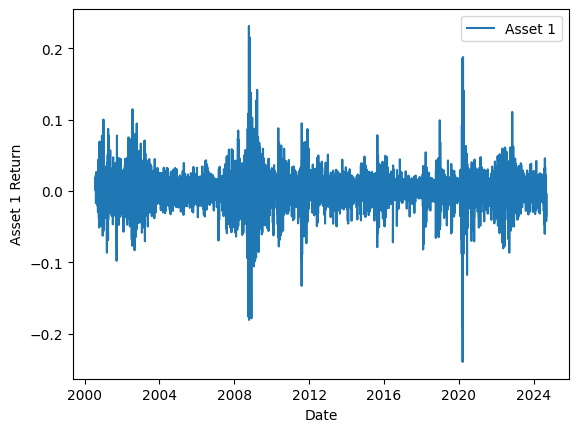

In [4]:
# Visual
plt.plot(df.index, df['Asset 1'], label='Asset 1')

plt.legend()
plt.xlabel('Date')
plt.ylabel('Asset 1 Return')

plt.show()

Non seasonal Time-series data

# Apply the ARIMA model

## Stationarity Check

In [5]:
def adf_kpss_test(timeseries):
    def adf_test(timeseries):
        #Perform Dickey-Fuller test:
        print ('Results of Dickey-Fuller Test:')
        dftest = adfuller(timeseries, autolag='AIC')
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value
    
    adf_test(timeseries)

    ad_fuller_results = adfuller(timeseries)
    ad_fuller_pval = ad_fuller_results[1]
    ad_fuller_bool = ad_fuller_pval <= 0.05

    print(f'Stationarity from ad_fuller test: {ad_fuller_bool} \n')
 
    def kpss_test(timeseries, trend='c'):
        print ('Results of KPSS Test:')
        kpsstest = kpss(timeseries, regression=trend)
        kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
        for key,value in kpsstest[3].items():
            kpss_output['Critical Value (%s)'%key] = value
        
    kpss_test(timeseries)
    kpss_test_results = kpss(timeseries)
    kpss_pval = kpss_test_results[1]
    kpss_test_bool = kpss_pval >= 0.05

    print(f'Stationarity from KPSS test: {kpss_test_bool}')

In [6]:
for col in df.columns:
    print(f'Stationarity Check for {col}')
    adf_kpss_test(df[col])
    print('--------------------------------')

Stationarity Check for Asset 1
Results of Dickey-Fuller Test:
Stationarity from ad_fuller test: True 

Results of KPSS Test:
Stationarity from KPSS test: True
--------------------------------
Stationarity Check for Asset 2
Results of Dickey-Fuller Test:
Stationarity from ad_fuller test: True 

Results of KPSS Test:
Stationarity from KPSS test: False
--------------------------------
Stationarity Check for Asset 3
Results of Dickey-Fuller Test:
Stationarity from ad_fuller test: True 

Results of KPSS Test:
Stationarity from KPSS test: True
--------------------------------
Stationarity Check for Asset 4
Results of Dickey-Fuller Test:
Stationarity from ad_fuller test: True 

Results of KPSS Test:
Stationarity from KPSS test: False
--------------------------------
Stationarity Check for Asset 5
Results of Dickey-Fuller Test:
Stationarity from ad_fuller test: True 

Results of KPSS Test:
Stationarity from KPSS test: True
--------------------------------
Stationarity Check for Asset 6
Results

# Adding Tune on ARIMA parameters

In [ ]:
# Create an empty DataFrame to store the rolling predictions
rolling_predictions_df = pd.DataFrame()

# Function to find the best (p,d,q) for a given asset
def find_best_arima_params(train_data):
    # Define the p, d, q ranges to search over
    # p = range(0, 5)
    # d = range(0, 2)
    # q = range(0, 5)

    p = range(0, 16)
    d = range(0, 2)
    q = range(0, 16)
    
    # Create a list of all possible (p, d, q) combinations
    pdq_combinations = list(itertools.product(p, d, q))
    
    best_mse = float("inf")
    best_order = None
    
    # Grid search through all combinations of (p, d, q)
    for param in pdq_combinations:
        try:
            # Fit ARIMA model
            model = ARIMA(train_data, order=param)
            model_fit = model.fit()
            
            # Forecast for the length of the validation set (we will use 20% of the data as a validation set)
            validation_size = int(len(train_data) * 0.2)
            forecast = model_fit.forecast(steps=validation_size)
            
            # Calculate the MSE for the validation set
            validation_data = train_data[-validation_size:]
            mse = mean_squared_error(validation_data, forecast)
            
            # If current MSE is better (lower), update the best params
            if mse < best_mse:
                best_mse = mse
                best_order = param
                
        except Exception as e:
            continue
    
    return best_order

# Function to perform rolling ARIMA predictions using a fixed (p,d,q) for each asset
def fit_rolling_arima_and_predict(data, asset_name, best_order, train_size_ratio=0.8, test_window=5):
    data_length = len(data)
    train_size = int(data_length * train_size_ratio)  # Define the size of the training set
    best_forecasts = []  # To store predictions from each rolling step

    for start in range(0, data_length - train_size - test_window + 1, test_window):
        train = data[start:start + train_size]
        test = data[start + train_size:start + train_size + test_window]

        try:
            # Fit ARIMA model with the best parameters
            model = ARIMA(train, order=best_order)
            model_fit = model.fit()
            
            # Forecast the same length as the test set
            forecast = model_fit.forecast(steps=len(test))
            
            # Append the forecast to the list of rolling predictions
            best_forecasts.extend(forecast)
            
        except Exception as e:
            print(f"Error for {asset_name} in rolling step: {e}")
            continue

    # Save the final rolling predictions to the DataFrame
    rolling_predictions_df[asset_name] = pd.Series(best_forecasts, index=data.index[-len(best_forecasts):])

# Dictionary to store the best (p,d,q) and MSE for each asset
best_params_dict = {}

# Iterate over each asset, tune ARIMA model once, and apply rolling ARIMA model
for asset in df.columns:
    asset_data = df[asset].dropna()
    
    # Step 1: Find the best ARIMA(p,d,q) for the asset
    best_order = find_best_arima_params(asset_data)
    best_params_dict[asset] = best_order
    
    print(f"{asset} - Best ARIMA(p,d,q): {best_order}")
    
    # Step 2: Apply rolling prediction using the best ARIMA parameters
    fit_rolling_arima_and_predict(asset_data, asset, best_order)

params_df = pd.DataFrame.from_dict(best_params_dict, orient='index', columns=['p', 'd', 'q'])


Asset 1 - Best ARIMA(p,d,q): (4, 1, 4)
Asset 2 - Best ARIMA(p,d,q): (0, 1, 1)
Asset 3 - Best ARIMA(p,d,q): (2, 1, 1)
Asset 4 - Best ARIMA(p,d,q): (0, 1, 1)
Asset 5 - Best ARIMA(p,d,q): (2, 1, 2)
Asset 6 - Best ARIMA(p,d,q): (4, 1, 0)
Asset 7 - Best ARIMA(p,d,q): (1, 1, 2)
Asset 8 - Best ARIMA(p,d,q): (3, 1, 4)
Asset 9 - Best ARIMA(p,d,q): (1, 1, 2)
Asset 10 - Best ARIMA(p,d,q): (2, 1, 4)
Asset 11 - Best ARIMA(p,d,q): (2, 0, 2)


In [9]:
rolling_predictions_df

,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
Date,,,,,,,,,,,
2019-11-18,0.001888,0.001275,0.000661,0.000200,0.001318,-0.010877,0.000822,0.001778,0.000198,-0.000129,0.000211
2019-11-19,0.000002,0.001275,0.000516,0.000200,0.000554,-0.004143,0.000064,0.002437,0.000541,0.001011,0.000350
2019-11-20,0.001051,0.001275,0.000494,0.000200,0.000941,-0.006506,0.000791,-0.000603,0.000200,-0.000048,0.000374
2019-11-21,0.001965,0.001275,0.000497,0.000200,0.000591,-0.004078,0.000094,-0.001374,0.000539,0.000412,0.000327
2019-11-22,0.000502,0.001275,0.000497,0.000200,0.000927,-0.004708,0.000762,0.001217,0.000202,0.000705,0.000290
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-30,-0.001032,0.001431,0.000832,-0.000099,-0.005213,0.009289,0.000633,-0.002729,-0.000631,0.000772,-0.000493
2024-09-03,0.000639,0.001431,-0.000791,-0.000099,0.001335,0.014233,0.000556,-0.001992,-0.000188,0.000612,0.000228
2024-09-04,0.001768,0.001431,-0.000263,-0.000099,0.000809,0.017054,0.000632,0.001766,-0.000629,0.001207,0.000766


In [10]:
df

,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
Date,,,,,,,,,,,
2000-07-31,0.015154,0.075677,-0.002266,0.000897,0.042162,0.004952,0.037313,0.002093,-0.002477,-0.008385,-0.031787
2000-08-01,0.009898,-0.049140,0.007874,0.006272,-0.011478,0.040433,-0.029227,0.010693,0.009594,0.000455,0.014613
2000-08-02,0.000718,-0.017754,0.001530,0.003732,0.009817,-0.009512,-0.000527,0.000973,0.011188,0.001176,0.018693
2000-08-03,0.019197,0.076083,0.007209,0.003099,-0.003059,-0.020954,-0.030686,-0.009466,0.006064,-0.026208,0.007214
2000-08-04,0.014248,-0.002954,0.006556,0.006231,0.016388,-0.024891,0.012934,0.004234,-0.001179,-0.003552,0.032614
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-30,0.020258,0.025782,-0.014374,-0.004687,0.013532,0.019439,0.004269,0.003950,0.007001,-0.014495,-0.023913
2024-09-03,-0.042311,-0.063077,0.022496,0.007809,-0.061795,0.001921,-0.038360,-0.039868,0.002796,-0.008582,-0.039190
2024-09-04,-0.003333,-0.004047,0.024987,0.009675,-0.003905,0.004290,-0.005114,-0.000679,-0.009153,0.002046,-0.018557


In [ ]:
rolling_predictions_df.to_csv('ARIMA_prediction.csv')

# Visualizations on predicted returns

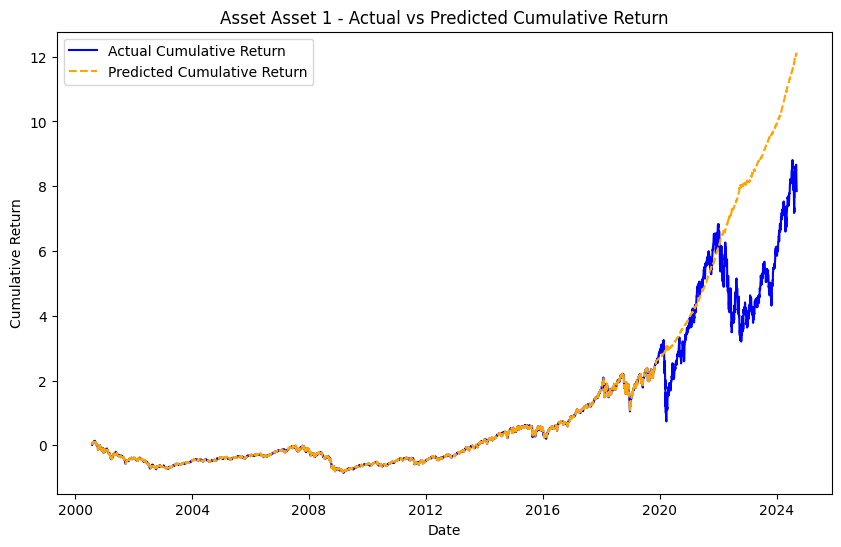

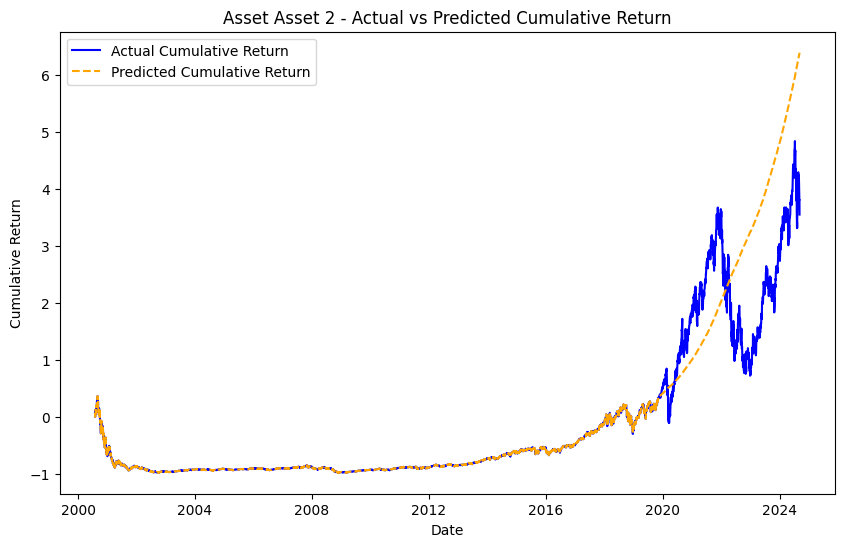

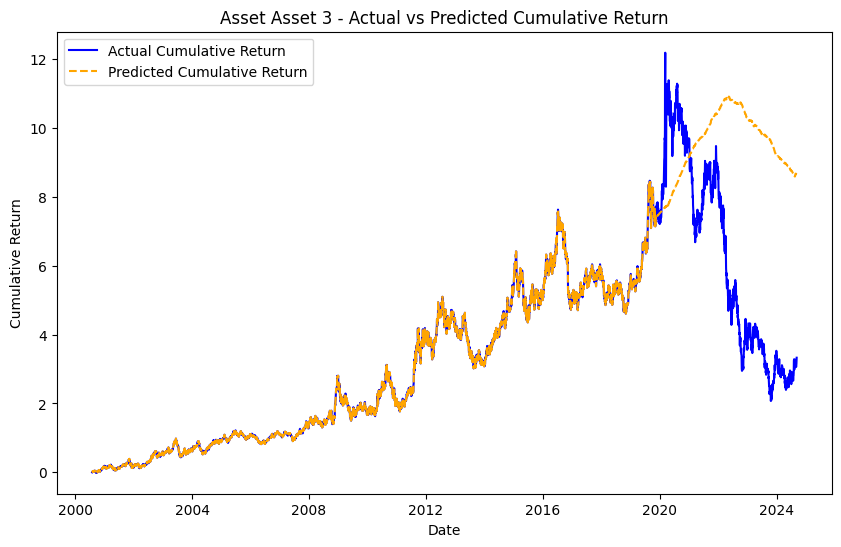

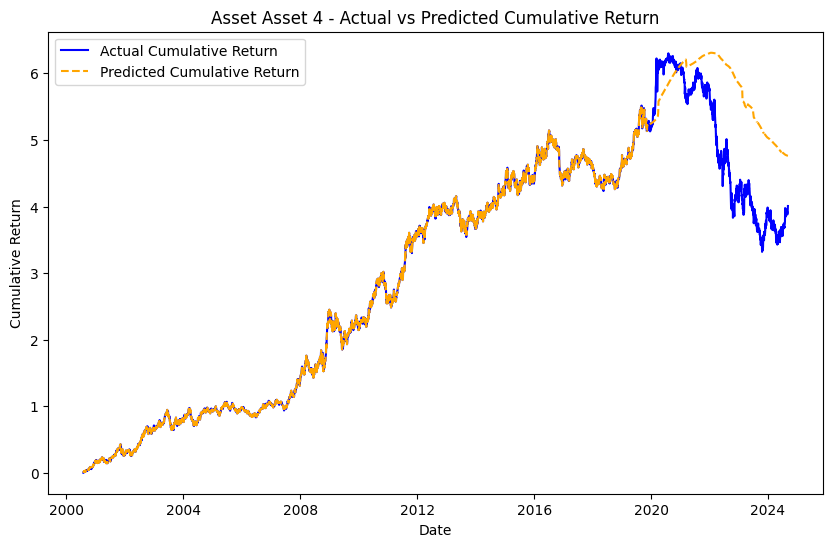

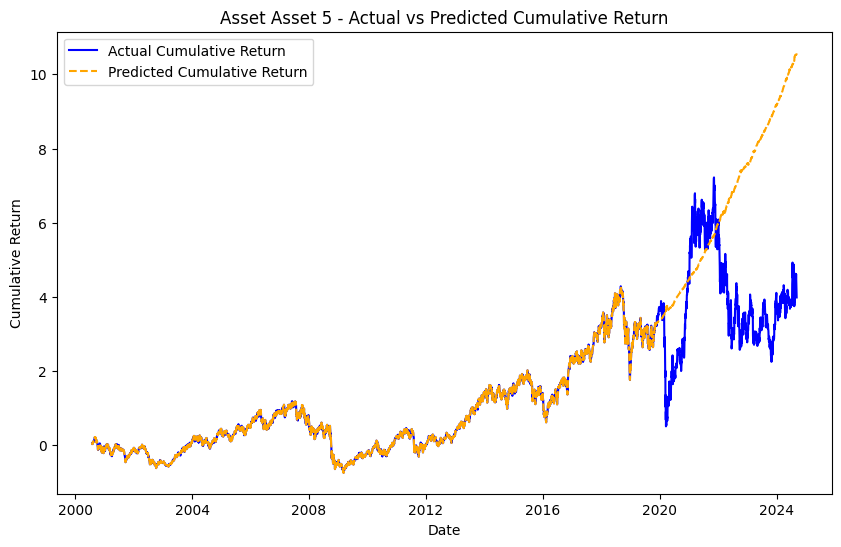

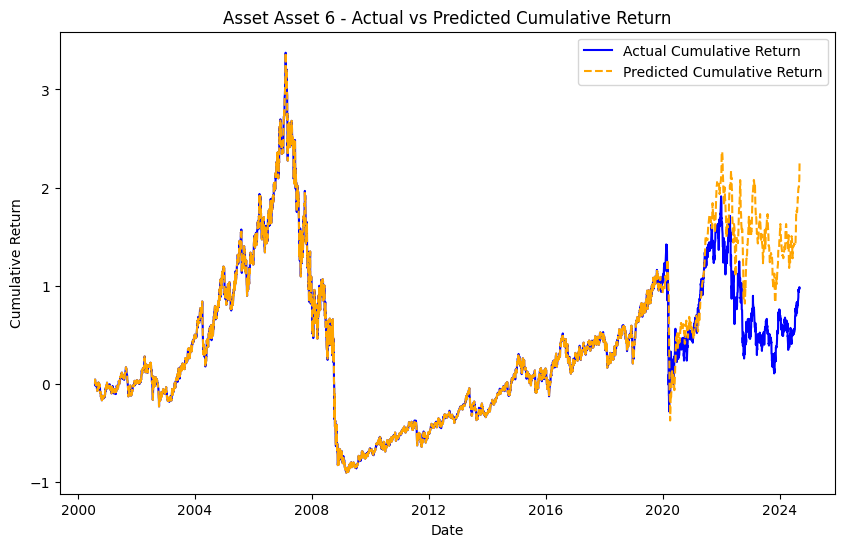

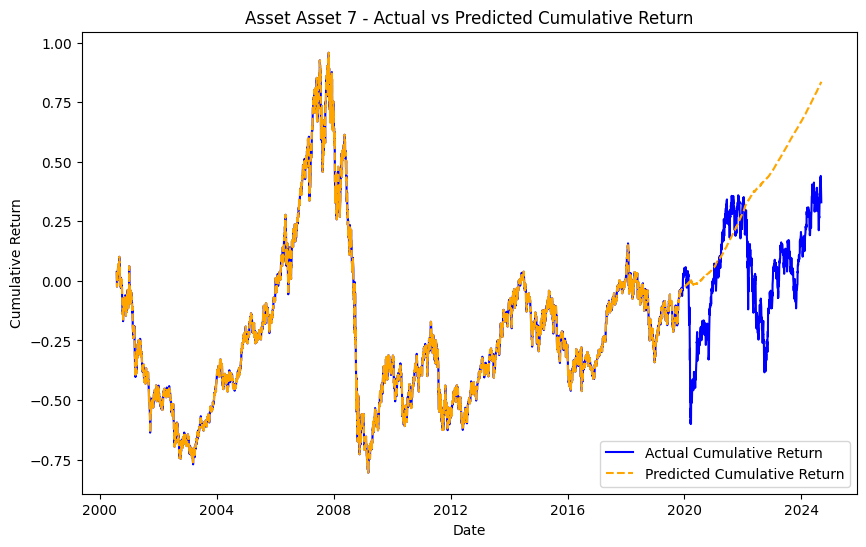

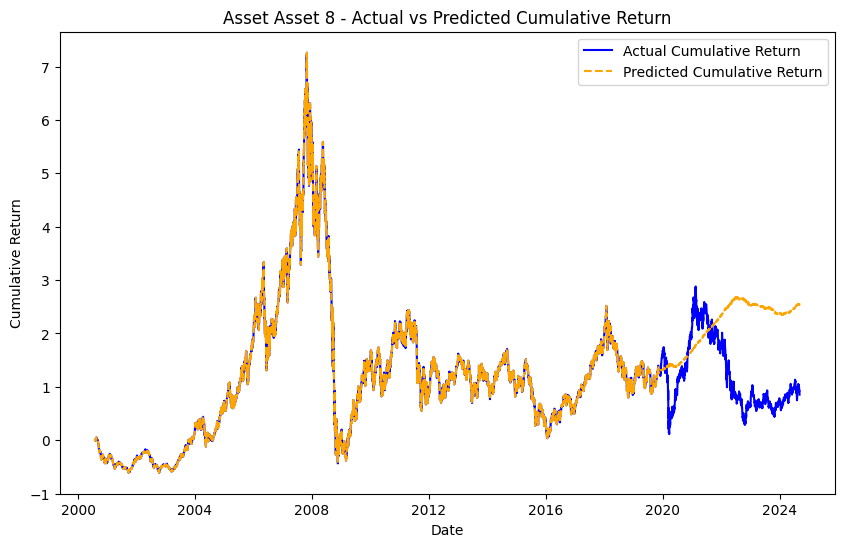

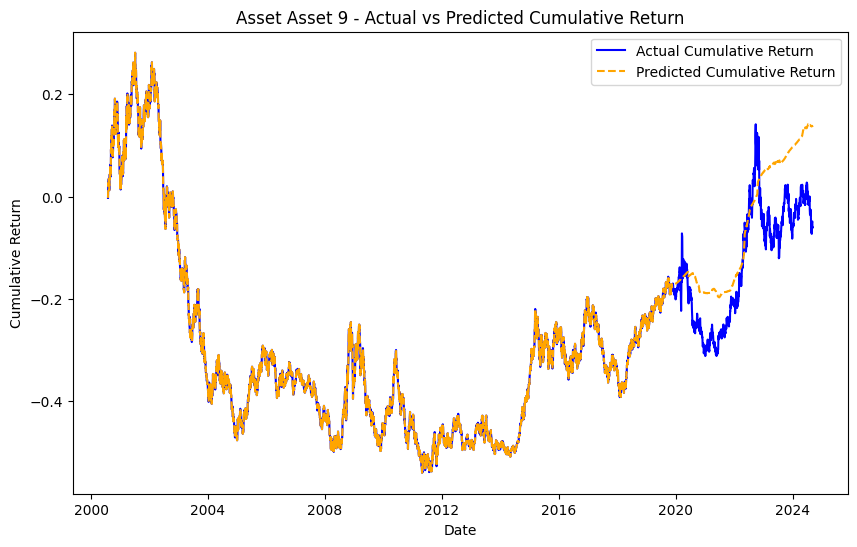

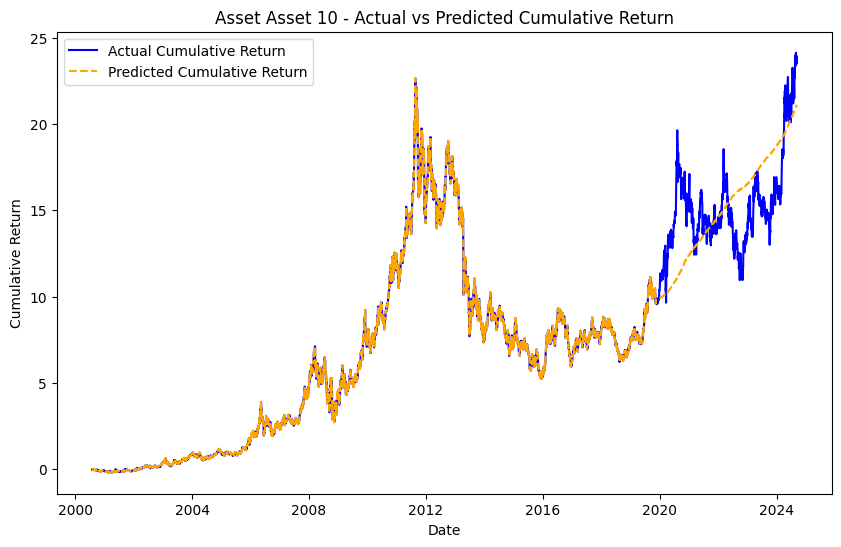

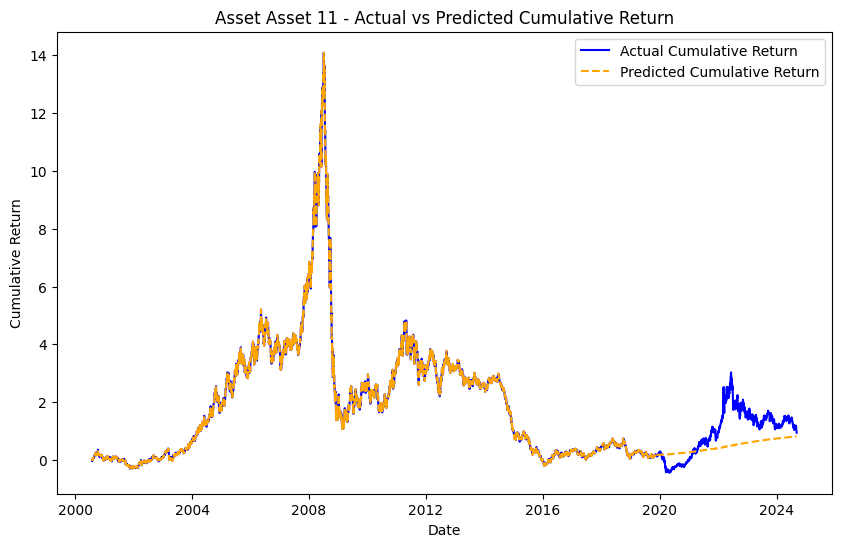

In [11]:
# We will align the dates for the predictions and fill missing values with the original data

# Step 1: Align the indices and combine actual data with predictions
best_predictions_full_aligned = df.copy()

# Only insert the predicted values from their respective start date onwards
for asset in rolling_predictions_df.columns:
    prediction_start_date = rolling_predictions_df.index[0]
    best_predictions_full_aligned.loc[prediction_start_date:, asset] = rolling_predictions_df[asset]

# Step 2: Calculate cumulative returns for both actual and predicted values
df_cumulative = (1 + df).cumprod() - 1  # Cumulative returns for actual data
best_predictions_cumulative = (1 + best_predictions_full_aligned).cumprod() - 1  # Cumulative returns for predictions

# Step 3: Plot cumulative returns for each asset
for asset in df.columns:
    plt.figure(figsize=(10, 6))

    # Plot actual cumulative returns
    plt.plot(df_cumulative.index, df_cumulative[asset], label='Actual Cumulative Return', color='blue')
    
    # Plot predicted cumulative returns
    plt.plot(best_predictions_cumulative.index, best_predictions_cumulative[asset], label='Predicted Cumulative Return', color='orange', linestyle='dashed')
    
    # Customize the plot
    plt.title(f'Asset {asset} - Actual vs Predicted Cumulative Return')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    
    # Show the plot
    plt.show()